# Spaceship Titanic

**Project Brief**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**Variables:**

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**To be Continued:**

- Exploring different imputations for missing data (KNN)
- Constructing a pipeline
- Tidying up the notebook and better annotation

## 1. Importing Packages & Data

In [1009]:
## Importing relevant packages


import pandas as pd
import plotly.express as px
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import RandomizedSearchCV
from collinearity import SelectNonCollinear
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
import beepy as beep

from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

import timeit
from sklearn.tree import DecisionTreeClassifier

from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras

import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import featuretools as ft

In [1010]:
start = timeit.default_timer()

In [1011]:
## Importing the data and concating for easier data quality evaluation, cleaning & feature engineering

train=pd.read_csv('train.csv')

test=pd.read_csv('test.csv')

data = pd.concat([train, test], axis=0,ignore_index=True)

## 2. EDA in seperate notebook

## 3. Data Cleaning

In [1012]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


This portion of the notebook focuses on imputing missing values, as discovered in the exploratory data analysis notebook there were no duplicate entries

In [1013]:
## Checking for missing values
data.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

**Part 1:** Passengers travelling in groups share some common characteristics, so for those passengers we will fill missing values based on the group's mode for appropriate variables

In [1014]:
## Some feature engineering for better cleaning

##Identifying group passengers as a way to impute cleaner values
data['PassengerId_Group']= data['PassengerId'].str[:4]

In [1015]:
def fast_mode(df, key_cols, value_col):
    """ 
    Calculate a column mode, by group, ignoring null values. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame over which to calcualate the mode. 
    key_cols : list of str
        Columns to groupby for calculation of mode.
    value_col : str
        Column for which to calculate the mode. 

    Return
    ------ 
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, 
        returns the one which is sorted first. 
    """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

In [1016]:
data.loc[data.HomePlanet.isnull(), 'HomePlanet'] = data.PassengerId_Group.map(fast_mode(data,['PassengerId_Group'], 
                                                            'HomePlanet').set_index('PassengerId_Group').HomePlanet)

data.loc[data.Transported.isnull(), 'Transported'] = data.PassengerId_Group.map(fast_mode(data,['PassengerId_Group'],
                                                            'Transported').set_index('PassengerId_Group').Transported)

**Part 2:** For the remaning missing values, we will utilize different imputation methodology based on the circumstances of the variable

**Spend Variables**

'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'

Since the median was 0 for all these variables, we will use it to replace missing values

In [1017]:
cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
data[cols] = data[cols].replace(np.nan,0)

**VIP**

Only about 2% of passengers were considered VIPs, so we will assume those with missing values are not VIPs

In [1018]:
data['VIP'] = data['VIP'].replace(np.nan,False).astype(int)

**Age**

We will use median to replace missing values

In [1019]:
data['Age'] = data['Age'].replace(np.nan,data.Age.median())

**CyroSleep**

We will use the mode

In [1020]:
data['CryoSleep']=data['CryoSleep'].fillna(data['CryoSleep'].mode()[0])

**Home Planet**

We will use the mode

In [1021]:
data['HomePlanet']=data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])

**Destination**

We will use the mode

In [1022]:
data['Destination']=data['Destination'].fillna(data['Destination'].mode()[0])

**Cabin**

We will impute according to the nearest row

In [1023]:
data['Cabin'] = data['Cabin'].fillna(method='ffill')

**Name**

We will impute according to the nearest row

In [1024]:
data['Name'] = data['Name'].fillna(method='ffill')

**Target Encoding**

In [1025]:
#HomePlanet, Destination 

cols=['HomePlanet','Destination']

for var in cols:
    data[str(var)+'_target']= data[var].map(dict(train.groupby(var)['Transported'].mean()))

In [1026]:
## We now have a clean dataset

data.isna().sum()

PassengerId              0
HomePlanet               0
CryoSleep                0
Cabin                    0
Destination              0
Age                      0
VIP                      0
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
Name                     0
Transported           4277
PassengerId_Group        0
HomePlanet_target        0
Destination_target       0
dtype: int64

## 4. Feature Engineering

This portion of the notebook will deal with the transformation of categorical variables and creating new variables derived from the originals that might have greater predictive power

### Transforming Categorical Variables

**Name**

In [1027]:
## Splitting Name and creating the Surname variable

data['Surname']=data['Name'].str.split(n=2).str[-1].str.upper()

data['Number_of_same_surname']=data['Surname'].map(dict(data['Surname'].value_counts()))

**PassengerID**

In [1028]:
## Passenger ID variable
data['PassengerId_Single']=data['PassengerId'].str[-2:]

In [1029]:
## Creating number in group variable
data['number_in_group']=data['PassengerId_Group'].map(dict(data['PassengerId_Group'].value_counts()))

**Cabin**

In [1030]:
## Creating Cabin number variable
data['Cabin_number']=data['Cabin'].str[2:-2]

In [1031]:
## Creating Cabin Side variable (one-hot-encoding since binary)
data['Cabin_Side_P']=data['Cabin'].str[-1].map({"P":1, "S":0})

In [1032]:
## Creating Cabin deck variable for datasets

train['Cabin_Deck']=train['Cabin'].str[0]
data['Cabin_Deck']=data['Cabin'].str[0]

## Target Encoding
data['Cabin_Deck_target']= data['Cabin_Deck'].map(dict(train.groupby('Cabin_Deck')['Transported'].mean()))

In [1033]:
data['Cabins_Deck_ABCD']=data['Cabin_Deck'].isin(['A','B','C','D'])
data['Cabins_Deck_EFGT']=data['Cabin_Deck'].isin(['E','F','G','T'])

data['Cabins_Deck_AFGE']=data['Cabin_Deck'].isin(['A','F','G','E'])
data['Cabins_Deck_BCDT']=data['Cabin_Deck'].isin(['B','C','D','T'])


data['Cabins_Deck_ABGT']=data['Cabin_Deck'].isin(['A','B','G','T'])
data['Cabins_Deck_EFCD']=data['Cabin_Deck'].isin(['E','F','C','D'])

In [1034]:
data['Side_P_Cabins_Deck_ABCD']= (data['Cabins_Deck_ABCD']==True)&(data['Cabin_Side_P']==True)
data['Side_P_Cabins_Deck_EFGT']= (data['Cabins_Deck_EFGT']==True)&(data['Cabin_Side_P']==True)

data['Cabin_Decks_AFGE']=(data['Cabins_Deck_AFGE']==True)&(data['Cabin_Side_P']==True)
data['Cabin_Decks_BCDT']=(data['Cabins_Deck_BCDT']==True)&(data['Cabin_Side_P']==True)

data['Side_P_Cabins_Deck_ABGT']=(data['Cabins_Deck_ABGT']==True)&(data['Cabin_Side_P']==True)
data['Side_P_Cabins_Deck_EFCD']=(data['Cabins_Deck_EFCD']==True)&(data['Cabin_Side_P']==True)

In [1035]:
## One hot encoding

for cabin in data['Cabin_Deck'].unique():
    data['Cabin_Deck'+str(cabin)]= data['Cabin_Deck'].map(lambda x: True if x == cabin else False) 

### New Features Engineered

In [1036]:
data['surname_multiplied_group_num']=data['Number_of_same_surname']*data['number_in_group']

In [1037]:
for planet in data['HomePlanet'].unique():
    data['HomePlanet_'+str(planet)]= data['HomePlanet'].map(lambda x: True if x == planet else False) 

In [1038]:
for destination in data['Destination'].unique():
    data['Destination_'+str(destination)]= data['Destination'].map(lambda x: True if x == destination else False) 

In [1039]:
## Tansportation routes

data['Route_Earth_TRAPPIST-1e']= (data['Destination_TRAPPIST-1e']==True)&(data['HomePlanet_Earth']==True)

data['Route_Earth_55 Cancri e']=(data['Destination_55 Cancri e']==True)&(data['HomePlanet_Earth']==True)

data['Route_Earth_PSO J318.5-22']=(data['Destination_PSO J318.5-22']==True)&(data['HomePlanet_Earth']==True)


In [1040]:
## Tansportation routes

data['Route_Mars_TRAPPIST-1e']= (data['Destination_TRAPPIST-1e']==True)&(data['HomePlanet_Mars']==True)

data['Route_Mars_55 Cancri e']=(data['Destination_55 Cancri e']==True)&(data['HomePlanet_Mars']==True)

data['Route_Mars_PSO J318.5-22']=(data['Destination_PSO J318.5-22']==True)&(data['HomePlanet_Mars']==True)

In [1041]:
## Tansportation routes

data['Route_Europa_TRAPPIST-1e']= (data['Destination_TRAPPIST-1e']==True)&(data['HomePlanet_Europa']==True)

data['Route_Europa_55 Cancri e']=(data['Destination_55 Cancri e']==True)&(data['HomePlanet_Europa']==True)

data['Route_Europa_PSO J318.5-22']=(data['Destination_PSO J318.5-22']==True)&(data['HomePlanet_Europa']==True)

route_cols = [col for col in data.columns if 'Route' in col]

In [1042]:
## Spend Variables

## Log transformations (smoothing)


data['TotalSpend']= data['RoomService']+data['FoodCourt']+ data['ShoppingMall']+ data['Spa']+ data['VRDeck']


cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

for var in cols:
    data[str(var)+'_log']= data[var].map(lambda i: np.log(i) if i > 0 else 0)

    
## Different Combinations of Spend


data['RoomService+FoodCourt_Spend']=  data['RoomService']+data['FoodCourt']

data['RoomService+ShoppingMall_Spend']=  data['RoomService']+data['ShoppingMall']

data['RoomService+Spa_Spend']=  data['RoomService']+data['Spa']

data['RoomService+VRDeck_Spend']=  data['RoomService']+data['VRDeck']

data['FoodCourt+ShoppingMall_Spend']=  data['FoodCourt']+data['ShoppingMall']

data['FoodCourt+Spa_Spend'] =  data['FoodCourt']+data['Spa']

data['FoodCourt+VRDeck_Spend']=  data['FoodCourt']+data['VRDeck']

data['ShoppingMall+Spa_Spend']=  data['ShoppingMall']+data['Spa']

data['ShoppingMall+VRDeck_Spend']=  data['ShoppingMall']+data['VRDeck']

data['Spa+VRDeck_Spend']=  data['Spa']+data['VRDeck']


In [1043]:
## Age Variables

data['Age_log']= data['Age'].map(lambda x: np.log(x) if x > 0 else 0)

data['Age_Zero']= data['Age'].apply(lambda x: True if x ==0 else False)

data['Age_Infant']= data['Age'].apply(lambda x: True if x <= 5 else False)

data['Age_Child']= data['Age'].apply(lambda x: True if x <= 12 else False)

data['Age_Teen']= data['Age'].apply(lambda x: True if x <= 18 else False)

data['Age_Elder']= data['Age'].apply(lambda x: True if x >= 60 else False)

In [1044]:
## CyroSleep Variables


## CyroSleep in different Cabin Decks

for deck in data['Cabin_Deck'].unique():
    data['Cabin_Deck_CryoSleep_'+str(deck)]= (data['Cabin_Deck']==deck)&(data['CryoSleep']==True)
    
## CyroSleep for different Destinations

for dest in data['Destination'].unique():
    data['Destination_CryoSleep_'+str(dest)]= (data['Destination']==dest)&(data['CryoSleep']==True)
    
## CyroSleep for different HomePlanets

for home in data['HomePlanet'].unique():
    data['HomePlanet_CryoSleep_'+str(home)]= (data['HomePlanet']==home)&(data['CryoSleep']==True)
    
## CyroSleep Cabin Side

data['Cabin_Side_P_Cryosleep']= (data['Cabin_Side_P']==1)&(data['CryoSleep']==True)



In [1045]:
## VIP in different Cabin Decks
for deck in data['Cabin_Deck'].unique():
    data['Cabin_Deck_VIP_'+str(deck)]= (data['Cabin_Deck']==deck)&(data['VIP']==True)
    
## VIP Cabin Side
data['Cabin_Side_P_VIP']= (data['Cabin_Side_P']==1)&(data['VIP']==True)

In [1046]:
route_cols = [col for col in data.columns if 'Route' in col]

for route in route_cols:
    data[str(route)+'CyroSleep']=(data[route]==True)&(data['CryoSleep']==True)
    data[str(route)+'Age_log']=(data[route]==True)*data['Age_log']
    data[str(route)+'Age_Infant']=(data[route]==True)&(data['Age_Infant']==True)
    data[str(route)+'Age_Child']=(data[route]==True)&(data['Age_Child']==True)
    data[str(route)+'VIP']=(data[route]==True)&(data['VIP']==True)
    data[str(route)+'TotalSpend']=(data[route]==True)&(data['TotalSpend']==True)

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colu

In [1047]:
## Dropping Categorical Variables
data=data.drop(['HomePlanet','Destination','Cabin','Cabin_Deck','Name','Surname'], axis=1)

In [ ]:
## Replacing outliers
cols=data.columns

for col in cols:
    lower=data[col].quantile(0.03)
    upper=data[col].quantile(0.97)
    data[col]=np.where(data[col] <lower, lower,data[col])
    data[col]=np.where(data[col] >upper, upper,data[col])

In [1048]:
print(f'''The total number of variables considered is : {len(data.columns)-1}''')

The total number of variables considered is : 154


## 4. Feature Selection

In [1049]:
## Setting index
data=data.set_index('PassengerId', drop=True)


labelled=data[data['Transported'].notnull()==True]

X=labelled.drop(['Transported'], axis=1).astype(float)
y=labelled['Transported'].astype(int) 

We will now select the variables with the greatest predict power.

Initially a filter will be used to perform univariate statistical analysis to identify the most promising 100 featues.

A wrapper then will be used to explore the optimal number of variables and assess their predictive power using different combonations 

**Normalizing/Scaling the Data**

In [1050]:
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

**Filter Method (Univariate Tests)**

In [1051]:
## Filtering for the top 50 variables

fs = SelectKBest(score_func=f_classif,k=50)
X_selected = fs.fit_transform(X, y)

## Identifying the names and filtering for the columns
cols = fs.get_support(indices=True)
X=labelled[X.columns[cols]]
X.columns


/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning:

Features [ 82  97 110 115 116 122 127 128 131 132 134 140 146 149 150 152] are constant.

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning:

invalid value encountered in true_divide



Index(['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'HomePlanet_target',
       'Destination_target', 'Cabin_Deck_target', 'Cabins_Deck_ABCD',
       'Cabins_Deck_EFGT', 'Cabins_Deck_AFGE', 'Cabins_Deck_BCDT',
       'Side_P_Cabins_Deck_EFGT', 'Cabin_Decks_AFGE', 'Cabin_DeckB',
       'HomePlanet_Europa', 'HomePlanet_Earth', 'Route_Earth_TRAPPIST-1e',
       'Route_Europa_TRAPPIST-1e', 'Route_Europa_55 Cancri e', 'TotalSpend',
       'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log',
       'VRDeck_log', 'RoomService+ShoppingMall_Spend', 'RoomService+Spa_Spend',
       'RoomService+VRDeck_Spend', 'ShoppingMall+Spa_Spend',
       'ShoppingMall+VRDeck_Spend', 'Spa+VRDeck_Spend', 'Age_log',
       'Age_Infant', 'Age_Child', 'Cabin_Deck_CryoSleep_B',
       'Cabin_Deck_CryoSleep_F', 'Cabin_Deck_CryoSleep_G',
       'Cabin_Deck_CryoSleep_C', 'Destination_CryoSleep_TRAPPIST-1e',
       'Destination_CryoSleep_55 Cancri e', 'HomePlanet_CryoSleep_Europa',
       'HomePlanet_Cryo

**Normalizing/Scaling the Data**

In [1052]:
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

**Removing highly correlated variables to avoid multicollinearity (Optional)**

In [1053]:

def cal_vif(x):
    thresh = 10
    output= pd.DataFrame()
    k = x.shape [1]
    vif =[variance_inflation_factor (x.values, i) for i in range(x.shape [1])]
    for i in range(1,k):
        a = np.argmax (vif)
        if(vif[a]<=thresh):
            break
        if(i==1):
            print('Iteration no: ',i)
            print(f'''Variable {x.columns [a]} has the highest VIF with a score of : {vif[a]}''')
            output= x.drop (x.columns [a], axis=1)
            vif =[variance_inflation_factor (output.values,j) for j in range (output.shape[1])]
            print('')
        elif(i>1):
            print('Iteration no: ',i)
            print(f'''Variable {output.columns [a]} has the highest VIF with a score of : {vif[a]}''')
            print('')
            output = output.drop (output.columns [a], axis=1)
            vif = [variance_inflation_factor (output.values, j) for j in range (output.shape [1])]
    return(output)

vif_selected_features = cal_vif(X.astype(float))

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



Iteration no:  1
Variable CryoSleep has the highest VIF with a score of : inf

Iteration no:  2
Variable RoomService has the highest VIF with a score of : inf

Iteration no:  3
Variable Spa has the highest VIF with a score of : inf

Iteration no:  4
Variable VRDeck has the highest VIF with a score of : inf

Iteration no:  5
Variable HomePlanet_target has the highest VIF with a score of : inf

Iteration no:  6
Variable Cabins_Deck_ABCD has the highest VIF with a score of : inf

Iteration no:  7
Variable Cabins_Deck_AFGE has the highest VIF with a score of : inf

Iteration no:  8
Variable RoomService+ShoppingMall_Spend has the highest VIF with a score of : inf

Iteration no:  9
Variable RoomService+Spa_Spend has the highest VIF with a score of : inf

Iteration no:  10
Variable HomePlanet_CryoSleep_Europa has the highest VIF with a score of : 183.8927946902367

Iteration no:  11
Variable Route_Europa_55 Cancri e has the highest VIF with a score of : 134.79912392293116

Iteration no:  12
V

In [1054]:
vif_selected_features.columns

Index(['Destination_target', 'Cabin_Deck_target', 'Cabins_Deck_BCDT',
       'Cabin_Decks_AFGE', 'Cabin_DeckB', 'HomePlanet_Earth',
       'Route_Europa_TRAPPIST-1e', 'TotalSpend', 'RoomService_log',
       'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log',
       'RoomService+VRDeck_Spend', 'ShoppingMall+Spa_Spend',
       'ShoppingMall+VRDeck_Spend', 'Spa+VRDeck_Spend', 'Age_log',
       'Age_Infant', 'Age_Child', 'Cabin_Deck_CryoSleep_B',
       'Cabin_Deck_CryoSleep_F', 'Cabin_Deck_CryoSleep_G',
       'Cabin_Deck_CryoSleep_C', 'Destination_CryoSleep_TRAPPIST-1e',
       'Destination_CryoSleep_55 Cancri e', 'Cabin_Side_P_Cryosleep',
       'Route_Earth_TRAPPIST-1eAge_log', 'Route_Mars_TRAPPIST-1eCyroSleep',
       'Route_Mars_TRAPPIST-1eAge_Child', 'Route_Europa_TRAPPIST-1eCyroSleep',
       'Route_Europa_55 Cancri eCyroSleep', 'Route_Europa_55 Cancri eAge_log'],
      dtype='object')

In [1055]:
X=labelled[vif_selected_features.columns]

**Normalizing/Scaling the Data**

In [1056]:
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

**Wrapper (Forward Step Selection with Logistic Regression)**

In [1057]:
## Selecting the 20-30

sfs1 = SFS(RandomForestRegressor(n_estimators=50),
           k_features=(10,len(X.columns)),
           forward=False,
           floating=True,cv=3)
sfs1.fit(X, y)

SequentialFeatureSelector(cv=3, estimator=LogisticRegression(max_iter=10000),
                          floating=True, forward=False, k_features=(15, 33))

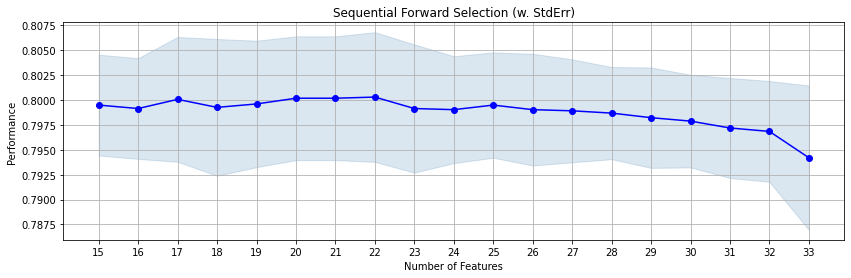

In [1058]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err',figsize=(14, 4))


plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [1059]:
print(f'{len(sfs1.k_feature_names_)} Features and Accuracy Score: {sfs1.k_score_}')

22 Features and Accuracy Score: 0.8003005814459941


In [1060]:
predictors=list(sfs1.k_feature_names_)
predictors

['Destination_target',
 'Cabin_Deck_target',
 'Cabins_Deck_BCDT',
 'TotalSpend',
 'RoomService_log',
 'VRDeck_log',
 'RoomService+VRDeck_Spend',
 'ShoppingMall+Spa_Spend',
 'ShoppingMall+VRDeck_Spend',
 'Age_Infant',
 'Age_Child',
 'Cabin_Deck_CryoSleep_B',
 'Cabin_Deck_CryoSleep_F',
 'Cabin_Deck_CryoSleep_G',
 'Cabin_Deck_CryoSleep_C',
 'Destination_CryoSleep_TRAPPIST-1e',
 'Cabin_Side_P_Cryosleep',
 'Route_Mars_TRAPPIST-1eCyroSleep',
 'Route_Mars_TRAPPIST-1eAge_Child',
 'Route_Europa_TRAPPIST-1eCyroSleep',
 'Route_Europa_55 Cancri eCyroSleep',
 'Route_Europa_55 Cancri eAge_log']

## 4. Preperation for Modelling

**Preparing for submission**

In [1061]:
submissiontest=data[data['Transported'].notnull()==False]

In [1062]:
X=labelled[predictors]
y=labelled['Transported'].astype(int) 

**Normalizing/Scaling the Data**

In [1063]:
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

**Principal Components Analysis (Optional)**

**Splitting Training and Test**

In [1064]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,stratify = y)

**Fixing Target Leak**

In [1065]:
## Identifying which variables are target encoded
target_cols=X_train.columns[X_train.columns.str.contains('target')]

print(f'''The number of target encoded variables is: {len(target_cols)}''')

print(target_cols)

The number of target encoded variables is: 2
Index(['Destination_target', 'Cabin_Deck_target'], dtype='object')


In [1066]:
target_cols

Index(['Destination_target', 'Cabin_Deck_target'], dtype='object')

In [1067]:
if target_cols.size>0:
    
    ## removing the target string
    cols=[]
    for a_string in target_cols:
        new_string = a_string.replace("_target", "")
        cols.append(new_string)

    ## Identifying the X_train passengers in the original dataset
    intersection = set(X_train.index).intersection(labelled.index) 

    ##Filling the missing values that we previously did

    for var in cols:
        train[var]=train[var].fillna(train[var].mode()[0])

    ## Extracting their rows
    train_encoding=train[train['PassengerId'].isin(intersection)]
    train_encoding=train_encoding.set_index('PassengerId', drop=True)


    ## Recalculating Target Encoding
    for var in cols:
        train_encoding[str(var)+'_target']= train_encoding[var].map(dict(train.groupby(var)['Transported'].mean()))

    ## Sorting the values of X_train so that passenger index matches the target encoding table
    X_train=X_train.sort_index()
    y_train=y_train.sort_index()

    ## Adding the columns
    for var in cols:
        X_train[str(var)+'_target'] =train_encoding[str(var)+'_target']

    ## Repeating for X test
    test_encoding=train[~train['PassengerId'].isin(intersection)]
    test_encoding=test_encoding.set_index('PassengerId', drop=True)

    for var in cols:
        test_encoding[str(var)+'_target']= test_encoding[var].map(dict(train_encoding.groupby(var)['Transported'].mean()))

    X_test=X_test.sort_index()
    y_test=y_test.sort_index()
    
    for var in cols:
        X_test[str(var)+'_target'] =test_encoding[str(var)+'_target']
    

## 5. Modelling

**Exploring different models**

In [1068]:
models=[]
train_scores1=[]
test_scores1=[]

classifiers = [
    LogisticRegression(max_iter=10000),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    lgb.LGBMClassifier(),
    CatBoostClassifier(verbose=False),
    XGBClassifier(disable_default_eval_metric = True)]

for classifier in classifiers:
    classifier.fit(X_train, y_train) 
    y_pred=classifier.predict(X_test)
    print(classifier)
    print("Train model score: %.3f" % classifier.score(X_train, y_train))
    print("Test model Score: %.3f" % classifier.score(X_test, y_test))
    models.append(type(classifier).__name__)
    train_scores1.append(classifier.score(X_train, y_train))
    test_scores1.append(classifier.score(X_test, y_test))
    print("\n")

    

LogisticRegression(max_iter=10000)
Train model score: 0.799
Test model Score: 0.808


RandomForestClassifier()
Train model score: 0.919
Test model Score: 0.798


GradientBoostingClassifier()
Train model score: 0.801
Test model Score: 0.799


AdaBoostClassifier()
Train model score: 0.787
Test model Score: 0.786


LGBMClassifier()
Train model score: 0.855
Test model Score: 0.808


Train model score: 0.841
Test model Score: 0.812


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
           

In [1069]:
scores=pd.DataFrame({
    'Train': train_scores1,
    'Test':  test_scores1},index=models)
scores

,Train,Test
LogisticRegression,0.798850,0.807515
RandomForestClassifier,0.919310,0.797546
GradientBoostingClassifier,0.801479,0.799463
AdaBoostClassifier,0.786524,0.786426
LGBMClassifier,0.854560,0.808282
CatBoostClassifier,0.840756,0.812117
XGBClassifier,0.889400,0.804831


In [1070]:
fig = px.histogram(scores, x=scores.index, y=["Train",'Test'], barmode='group',
             height=400)

fig.update_layout(
    height=500,
    title_text='Model Comparison (Train & Test Scores)',
    title_x=0.5,
    legend_title='',)

fig.update_xaxes(title_text='Models')
fig.update_yaxes(title_text='Accuracy Score',range=(scores['Test'].min()-0.05,scores['Train'].max()+0.05))
                 
fig.show()

## 5. Hypertuning Models

Performing gridsearch to identify what parameters can be modified in each model to optimize performance

**Random Forest**

In [1071]:
param_grid = {
    'n_estimators': [50, 100, 200 ,400],
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_features':['sqrt', 'log2', None],
    'min_samples_split':[1,2,4,6]
}


rf1 = RandomForestClassifier()

rf1grid_search = GridSearchCV(estimator = rf1,param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1072]:
rf1grid_search.fit(X, y)
rf1grid_search.best_params_

Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.0min finished


{'criterion': 'gini',
 'max_features': None,
 'min_samples_split': 6,
 'n_estimators': 100}

In [1073]:
rf2 = RandomForestClassifier()
rf2.set_params(**rf1grid_search.best_params_)

RandomForestClassifier(max_features=None, min_samples_split=6)

**Gradient Boosting**

In [1074]:
param_grid = {
    'n_estimators': [25,50, 100, 175 ,250],
    'max_depth': [2, 4,6,8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf':[1,2,3]
}


gb1 = GradientBoostingClassifier()

gb1grid_search = GridSearchCV(estimator = gb1, param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1075]:
gb1grid_search.fit(X, y)
gb1grid_search.best_params_

Fitting 2 folds for each of 180 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.9min finished


{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 250}

In [1076]:
gb2 = GradientBoostingClassifier()
gb2.set_params(**gb1grid_search.best_params_)

GradientBoostingClassifier(max_depth=4, max_features='auto', min_samples_leaf=2,
                           n_estimators=250)

**Adaptive Boosting**

In [1077]:
param_grid = {
    'base_estimator': [DecisionTreeClassifier(),LogisticRegression()],
    'n_estimators': [25,50,100,150,200],
    'learning_rate':[0.5,1,2,3]
}

ad1 = AdaBoostClassifier()

ad1grid_search = GridSearchCV(estimator = ad1, param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1078]:
ad1grid_search.fit(X, y)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.1s finished


GridSearchCV(cv=2, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(),
                                            LogisticRegression()],
                         'learning_rate': [0.5, 1, 2, 3],
                         'n_estimators': [25, 50, 100, 150, 200]},
             verbose=2)

In [1079]:
ad1grid_search.best_params_

{'base_estimator': LogisticRegression(),
 'learning_rate': 2,
 'n_estimators': 150}

In [1080]:
ad2 = AdaBoostClassifier()
ad2.set_params(**ad1grid_search.best_params_)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=2,
                   n_estimators=150)

**LGBM**

In [1081]:
param_grid = {
    'boosting_type':['gbdt','dart','rf','goss'],
    'n_leaves': [11,21,31,41,51],
    'n_estimators': [50,100,150,200,400],
    'learning_rate':[0.05,0.1,0.2,0.4]
}

lgb1 = lgb.LGBMClassifier()

lgb1grid_search = GridSearchCV(estimator = lgb1, param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1082]:
lgb1grid_search.fit(X, y)

Fitting 2 folds for each of 400 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.8min finished


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart', 'rf', 'goss'],
                         'learning_rate': [0.05, 0.1, 0.2, 0.4],
                         'n_estimators': [50, 100, 150, 200, 400],
                         'n_leaves': [11, 21, 31, 41, 51]},
             verbose=2)

In [1083]:
lgb1grid_search.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'n_estimators': 150,
 'n_leaves': 11}

In [1084]:
lgb2 = lgb.LGBMClassifier()
lgb2.set_params(**lgb1grid_search.best_params_)

LGBMClassifier(learning_rate=0.05, n_estimators=150, n_leaves=11)

**Catboost**

In [1085]:
param_grid = {#'loss_function':['Logloss','CrossEntropy','Accuracy','AUC'],
              'depth'  : [4,6,8],
              'learning_rate' : [0.01,0.03,0.1],
              #'iterations'    : [500, 1000,1500]
                 }
cat1 = CatBoostClassifier(verbose=False)

cat1grid_search = GridSearchCV(estimator = cat1, param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1086]:
cat1grid_search.fit(X, y)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   38.2s finished


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc4c669b150>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8],
                         'learning_rate': [0.01, 0.03, 0.1]},
             verbose=2)

In [1087]:
cat1grid_search.best_params_

{'depth': 6, 'learning_rate': 0.03}

In [1088]:
cat2 = CatBoostClassifier(verbose=False)
cat2.set_params(**cat1grid_search.best_params_)

**Xgboost**

In [1089]:
param_grid = {
    'n_estimators':[50,100,200,400],
    'gamma': [0,0.1,0.2],
    'max_depth': [4,6,8,10],
    'learning_rate':[0.01,0.2,0.300000012,0.5]
}

xgb1 = XGBClassifier(verbosity = 0)

xgb1grid_search = GridSearchCV(estimator = xgb1, param_grid = param_grid, cv = 2 ,  
                              n_jobs = -1, verbose = 2)

In [1090]:
xgb1grid_search.fit(X, y)

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  7.1min finished


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [1091]:
xgb1grid_search.best_params_

{'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}

In [1092]:
xgb2 = XGBClassifier()
xgb2.set_params(**xgb1grid_search.best_params_)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=0.2,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

**Hyper-Tuned Models**

In [1093]:
train_scores2=[]
test_scores2=[]
lr=LogisticRegression(max_iter=10000)

classifiers = [lr,rf2,gb2,ad2,lgb2,cat2,xgb2]

for classifier in classifiers:
    classifier.fit(X_train, y_train) 
    y_pred=classifier.predict(X_test)
    print(classifier)
    print("Train model score: %.3f" % classifier.score(X_train, y_train))
    print("Test model Score: %.3f" % classifier.score(X_test, y_test))
    train_scores2.append(classifier.score(X_train, y_train))
    test_scores2.append(classifier.score(X_test, y_test))
    print("\n")

LogisticRegression(max_iter=10000)
Train model score: 0.799
Test model Score: 0.808


RandomForestClassifier(max_features=None, min_samples_split=6)
Train model score: 0.909
Test model Score: 0.806


GradientBoostingClassifier(max_depth=4, max_features='auto', min_samples_leaf=2,
                           n_estimators=250)
Train model score: 0.859
Test model Score: 0.803


AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=2,
                   n_estimators=150)
Train model score: 0.795
Test model Score: 0.799


LGBMClassifier(learning_rate=0.05, n_estimators=150, n_leaves=11)
Train model score: 0.847
Test model Score: 0.811


Train model score: 0.855
Test model Score: 0.813


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_c

In [1094]:
scores=pd.DataFrame({
    'Pre_tuning': test_scores1,
    'Post_tuning':  test_scores2},index=models)

scores['Improvement (%)']= round(((scores['Post_tuning']-scores['Pre_tuning'])/scores['Pre_tuning'])*100,2)

scores

,Pre_tuning,Post_tuning,Improvement (%)
LogisticRegression,0.807515,0.807515,0.00
RandomForestClassifier,0.797546,0.805598,1.01
GradientBoostingClassifier,0.799463,0.802531,0.38
AdaBoostClassifier,0.786426,0.799463,1.66
LGBMClassifier,0.808282,0.810966,0.33
CatBoostClassifier,0.812117,0.812883,0.09
XGBClassifier,0.804831,0.807515,0.33


## 6. Ensemble Methods and Deep Learning

**Stacking**: Uses several model outputs to build a final model for prediction

In [1095]:
models = [('lr', lr),
          ('rf', rf2),
          ('gb',gb2),
         ('ad',ad2),
         ('lgb',lgb2),
         ('cat',cat2),
         ('xgb',xgb2)]

sclf = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

sclf = sclf.fit(X_train, y_train)

print("Accuracy:",sclf.score(X_test, y_test))


Accuracy: 0.8159509202453987


**Voting**: Uses several model outputs and decides a final prediction based on a majority vote

In [1096]:
models = [('lr', lr),
          ('rf', rf2),
          ('gb',gb2),
         ('ad',ad2),
         ('lgb',lgb2),
         ('cat',cat2),
         ('xgb',xgb2)]

vclf = VotingClassifier(estimators=models,voting='soft')

vclf = vclf.fit(X_train, y_train)

print("Accuracy:",vclf.score(X_test, y_test))

Accuracy: 0.8121165644171779


**Deep Learning**

In [1097]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X.shape[1]]),
    layers.Dense(1024, activation='relu', input_shape=[X.shape[1]]),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),    
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
12/12 [==============================] - 1s 100ms/step - loss: 0.8279 - binary_accuracy: 0.7044 - val_loss: 0.5368 - val_binary_accuracy: 0.6446
Epoch 2/100
12/12 [==============================] - 1s 82ms/step - loss: 0.5491 - binary_accuracy: 0.7487 - val_loss: 0.5410 - val_binary_accuracy: 0.6541
Epoch 3/100
12/12 [==============================] - 1s 94ms/step - loss: 0.5112 - binary_accuracy: 0.7599 - val_loss: 0.5284 - val_binary_accuracy: 0.6714
Epoch 4/100
12/12 [==============================] - 1s 101ms/step - loss: 0.4816 - binary_accuracy: 0.7699 - val_loss: 0.5327 - val_binary_accuracy: 0.6783
Epoch 5/100
12/12 [==============================] - 1s 83ms/step - loss: 0.4719 - binary_accuracy: 0.7739 - val_loss: 0.5199 - val_binary_accuracy: 0.7235
Epoch 6/100
12/12 [==============================] - 1s 98ms/step - loss: 0.4641 - binary_accuracy: 0.7740 - val_loss: 0.5273 - val_binary_accuracy: 0.7036
Epoch 7/100
12/12 [==============================] - 1s 117ms/

Best Validation Loss: 0.4007
Best Validation Accuracy: 0.8140


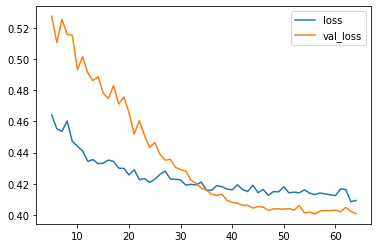

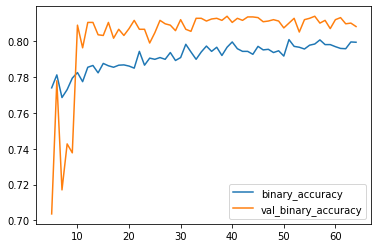

In [1098]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

## 7. Final Model Selection

In [1099]:
final=[lr,rf2,ad2,gb2,lgb2,cat2,xgb2,vclf,sclf]

In [1100]:
final_models=['LR','RF','AD','GB','LGB','CAT','XGB','Vote','Stack','NN']
final_scores=[]

for x in final:
    final_scores.append(x.score(X_test, y_test))


final_scores.append(history_df['val_binary_accuracy'].max())

final_summary=pd.DataFrame(final_scores,index=final_models,columns=['Score']).sort_values(by='Score',ascending=False)

In [1101]:
final_summary

,Score
Stack,0.815951
NN,0.814034
CAT,0.812883
Vote,0.812117
LGB,0.810966
LR,0.807515
XGB,0.807515
RF,0.805598
GB,0.802531
AD,0.799463


In [1102]:
print(f'''The best performing model is {final_summary.index[0]} with score of {final_summary.iloc[0,0]}''')

The best performing model is Stack with score of 0.8159509202453987


## 8. Final Submission

In [1103]:
X_train=labelled[predictors]

y_train=y

X_test=submissiontest[predictors]

In [1104]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),index=X_train.index, columns=X_train.columns)

In [1105]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test=pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

In [1114]:
sclf.fit(X_train, y_train)
y_pred=sclf.predict(X_test)

#y_pred = np.round(model.predict(X_test),0)

In [1115]:
submission=pd.DataFrame(y_pred.astype(bool),index=X_test.index).rename(columns={0: "Transported"})

In [1117]:
submission.to_csv('Submission_final.csv')

In [1110]:
#Your statements here

stop = timeit.default_timer()

print('Time: ', (stop - start)/60 ) 

beep.beep(4)

Time:  24.91508877861667
